In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import random

fileFashionTrainName = './datasetFashion/train-images-idx3-ubyte'
fileFashionTestName = './datasetFashion/t10k-images-idx3-ubyte'
fileFashionTrainLabelName = './datasetFashion/train-labels-idx1-ubyte'
fileFashionTestLabelName = './datasetFashion/t10k-labels-idx1-ubyte'

fileMNISTTrainName = './datasetMNIST/train-images.idx3-ubyte'
fileMNISTTestName = './datasetMNIST/t10k-images.idx3-ubyte'
fileMNISTTrainLabelName = './datasetMNIST/train-labels.idx1-ubyte'
fileMNISTTestLabelName = './datasetMNIST/t10k-labels.idx1-ubyte'

firstVersion = 'firstHead.pth'
secondHead = 'secondHead.pth'

In [2]:
class Preprocessing:
    def __init__(self, trainName, trainLabel, testName, testLabel, flag):
        self.flag = flag
        self.arrayTrainImg = torch.tensor(self._openImages(trainName, expected_magic=2051, expected_count=60000), dtype=torch.float32).unsqueeze(1)
        self.arrayTestImg = torch.tensor(self._openImages(testName, expected_magic=2051, expected_count=10000), dtype=torch.float32).unsqueeze(1)
        self.arrayTrainLabels = torch.tensor(self._openLabels(trainLabel, expected_magic=2049, expected_count=60000), dtype=torch.long)
        self.arrayTestLabels = torch.tensor(self._openLabels(testLabel, expected_magic=2049, expected_count=10000), dtype=torch.long)

        train_dataset = data_utils.TensorDataset(self.arrayTrainImg, self.arrayTrainLabels)
        test_dataset = data_utils.TensorDataset(self.arrayTestImg, self.arrayTestLabels)
        self.trainLoader = data_utils.DataLoader(train_dataset, batch_size=100, shuffle=True)
        self.testLoader = data_utils.DataLoader(test_dataset, batch_size=1000)
    
    def _openImages(self, filename, expected_magic, expected_count):
        images = []
        with open(filename, 'rb') as f:
            assert struct.unpack('>I', f.read(4))[0] == expected_magic
            count = struct.unpack('>I', f.read(4))[0]
            assert count == expected_count
            num_rows = struct.unpack('>I', f.read(4))[0]
            num_cols = struct.unpack('>I', f.read(4))[0]
            for i in range(count): images.append(np.frombuffer(f.read(num_rows * num_cols), dtype=np.uint8).reshape((num_rows, num_cols)))
        return np.array(images)
    
    def _openLabels(self, filename, expected_magic, expected_count):
        labels = []
        with open(filename, 'rb') as f:
            assert struct.unpack('>I', f.read(4))[0] == expected_magic
            count = struct.unpack('>I', f.read(4))[0]
            assert count == expected_count
            for i in range(count):
                label = struct.unpack('>B', f.read(1))[0]
                if self.flag == 1: label += 10
                labels.append(label)
        return np.array(labels)
    
    def showPictures(self):
        unique_labels = np.unique(self.arrayTrainLabels.numpy())
        _, axes = plt.subplots(nrows=1, ncols=len(unique_labels), figsize=(15, 3))
        
        for i, label in enumerate(unique_labels):
            idx = -1
            for j, curLabel in enumerate(self.arrayTrainLabels.numpy()):
                if curLabel == label:
                    idx = j
                    break  
            axes[i].imshow(self.arrayTrainImg[idx].squeeze(0), cmap='gray')
            axes[i].set_title(f"Label: {label}")
            axes[i].axis("off")
        plt.show()
        
    def returnLoaders(self):
        return self.trainLoader, self.testLoader


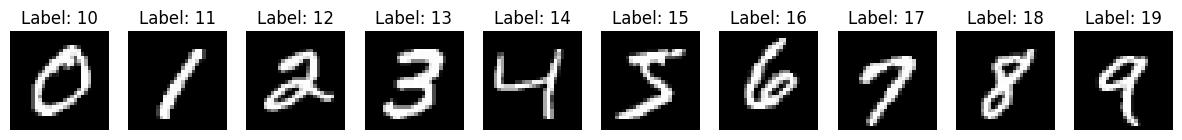

In [3]:
dataFashion = Preprocessing(fileFashionTrainName, fileFashionTrainLabelName, fileFashionTestName, fileFashionTestLabelName, 0)
dataMnist = Preprocessing(fileMNISTTrainName, fileMNISTTrainLabelName, fileMNISTTestName, fileMNISTTestLabelName, 1)
trainFashionLoader, testFashionLoader = dataFashion.returnLoaders()
trainMNISTLoader, testMNISTLoader = dataMnist.returnLoaders()
dataMnist.showPictures()

combined_train_dataset = data_utils.ConcatDataset([dataFashion.trainLoader.dataset, dataMnist.trainLoader.dataset])
combined_test_dataset  = data_utils.ConcatDataset([dataFashion.testLoader.dataset, dataMnist.testLoader.dataset])
combined_train_loader = data_utils.DataLoader(combined_train_dataset, batch_size=100, shuffle=True)
combined_test_loader  = data_utils.DataLoader(combined_test_dataset, batch_size=1000, shuffle=False)

In [ ]:
class myCNV(nn.Module):
    def __init__(self, trainFashionLoader, testFashionLoader, trainMNISTLoader, testMNISTLoader, combined_train_loader, combined_test_loader, numEpoch, lr):
        super(myCNV, self).__init__()
        self.trainFashionLoader = trainFashionLoader
        self.testFashionLoader = testFashionLoader
        
        self.trainMNISTLoader = trainMNISTLoader
        self.testMNISTLoader = testMNISTLoader
        
        self.trainCombinedLoader = combined_train_loader
        self.testCombinedLoader = combined_test_loader
        
        self.trainLoader = None
        self.testLoader = None
        
        self.headMode = None
        
        self.numEpoch = numEpoch
        self.lr = lr
        self.loss = nn.CrossEntropyLoss() # TODO 
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=3)  # outSize = 10
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=3)  # outSize = 4
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=512, kernel_size=3, padding=1, stride=3) # outSize = 2
        self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        
        self.headerFashion = nn.Linear(1024, 10)
        self.headerMNIST = nn.Linear(1024, 10)
        self.headerMix  = None
        
        self.layers = [self.conv1, self.conv2, self.conv3, self.conv4, self.headerFashion]

        self.optimizer = optim.Adam([
            {"params": self.conv1.parameters()},
            {"params": self.conv2.parameters()},
            {"params": self.conv3.parameters()},
            {"params": self.conv4.parameters()},
            {"params": self.headerFashion.parameters()},
            {"params": self.headerMNIST.parameters()}
        ], lr=self.lr)

        self.trainHistory = []
        self.testHistory = []
        
    def changeFlagLoader(self, head_mode):
        self.headMode = head_mode
        match head_mode:
            case 'fashion':
                self.trainLoader = self.trainFashionLoader
                self.testLoader = self.testFashionLoader
            case 'mnist': 
                self.trainLoader = self.trainMNISTLoader
                self.testLoader = self.testMNISTLoader
            case 'mix':
                self.trainLoader = self.trainCombinedLoader
                self.testLoader = self.testCombinedLoader

                
    def forward(self, x, head_mode=None):
        layers = nn.Sequential(
            self.conv1,
            self.dropout1,
            self.conv2,
            self.dropout2,
            self.conv3,
            self.dropout3,
            self.conv4
        )
        x = layers(x)
        x = x.view(x.size(0), -1)
        if head_mode == 'fashion':
            x = self.headerFashion(x)
        elif head_mode == 'mnist':
            x = self.headerMNIST(x)
        elif head_mode == 'mix' and self.headerMix is not None:
            x = self.headerMix(x)
        return x

    
    def myTrain(self, head_mode):
        self.trainHistory = []
        self.testHistory = []
        self.train()  
        for epoch in range(self.numEpoch):
            epochLoss = 0.0
            pbar = tqdm(self.trainLoader, desc=f"Epoch {epoch+1}/{self.numEpoch}", leave=False)
            for images, correctLabels in pbar:
                self.optimizer.zero_grad()
                logits = self.forward(images, head_mode)  
                if self.headMode == 'mnist' : correctLabels -= 10
                lossVal = self.loss(logits, correctLabels)
                lossVal.backward()
                self.optimizer.step()
                
                epochLoss += lossVal.item()
                pbar.set_postfix(loss=f"{lossVal.item():.4f}")
            
            trainLoss = epochLoss / len(self.trainLoader)
            self.trainHistory.append(trainLoss)
            
            self.eval()
            epoch_test_loss = 0.0
            with torch.no_grad():
                for images, correctLabels in self.testLoader:
                    logits = self.forward(images, head_mode)
                    if self.headMode == 'mnist' : correctLabels -= 10
                    lossVal = self.loss(logits, correctLabels)
                    epoch_test_loss += lossVal.item()
            testLoss = epoch_test_loss / len(self.testLoader)
            self.testHistory.append(testLoss)
        
            print(f"Epoch {epoch+1} - Train Loss: {trainLoss:.4f}, Test Loss: {testLoss:.4f}")
    
    def createCombinedHead(self):
        self.headerMix = nn.Linear(1024, 20)
        
        with torch.no_grad():
            self.headerMix.weight.data[:10] = self.headerFashion.weight.data.clone()
            self.headerMix.bias.data[:10] = self.headerFashion.bias.data.clone()
            self.headerMix.weight.data[10:] = self.headerMNIST.weight.data.clone()
            self.headerMix.bias.data[10:] = self.headerMNIST.bias.data.clone()

    def plotGraphics(self):
        epochs = range(1, self.numEpoch + 1)
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, self.trainHistory, label="Train Loss", marker="o")
        plt.plot(epochs, self.testHistory, label="Test Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def freezeParams(self):
        for curLay in self.layers:
            for param in curLay.parameters():
                param.requires_grad = False
                
            
    def unfreezeParams(self):
        for curLay in self.layers:
            for param in curLay.parameters():
                param.requires_grad = True
                        
    def saveParams(self, file2save):
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }
        torch.save(checkpoint, file2save)

    def loadParams(self, file2load):
        checkpoint = torch.load(file2load)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    def findMostSimiliar(self, firstLabel, secondLabel):
        self.eval()
        bestImg = None
        bestProb = -1.0
        
        with torch.no_grad():
            for images, labels in self.testLoader:
                if self.headMode == 'mnist': labels = labels - 10
                probs = F.softmax(self.forward(images, self.headMode), dim=1)        
                for i in range(len(labels)):
                    if labels[i].item() == firstLabel:
                        curr_prob = probs[i, secondLabel].item()
                        if curr_prob > bestProb:
                            bestProb = curr_prob
                            bestImg = images[i].detach().cpu()                 
        return bestImg, bestProb

    def findRandomImage(self, targetLabel):
        self.eval()
        with torch.no_grad():
            matching_images = []
            matching_labels = []
            
            for images, labels in self.testLoader:
                if self.headMode == 'mnist': 
                    labels = labels - 10  
                for i in range(len(labels)):
                    if labels[i].item() == targetLabel:
                        matching_images.append(images[i])
                        # matching_labels.append(labels[i])
            
            rand_index = random.randint(0, len(matching_images) - 1)
            return matching_images[rand_index]

    
    def plotImage(self, image):
        plt.figure()
        image = image.squeeze()
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()

Epoch 1 - Train Loss: 1.5123, Test Loss: 0.5823


Epoch 2 - Train Loss: 0.5182, Test Loss: 0.5477


Epoch 3 - Train Loss: 0.5138, Test Loss: 0.5621


Epoch 4 - Train Loss: 0.5270, Test Loss: 0.5541


Epoch 5 - Train Loss: 0.5225, Test Loss: 0.5545


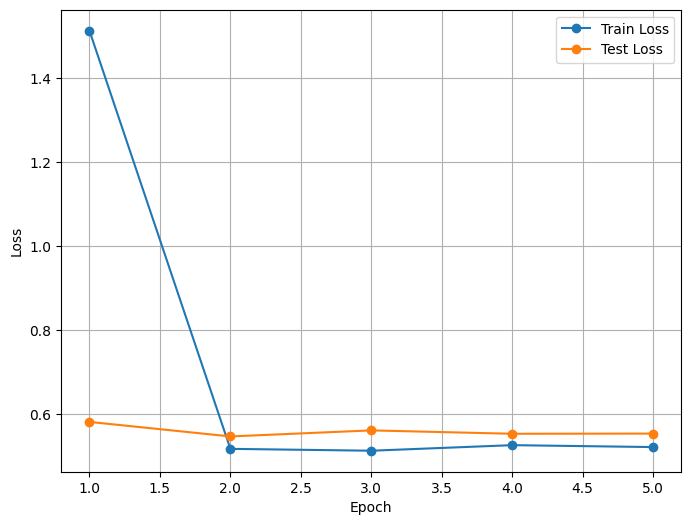

In [5]:
numEpoch = 5
lr = 0.001

model = myCNV(trainFashionLoader, testFashionLoader, trainMNISTLoader, testMNISTLoader, combined_train_loader, combined_test_loader, numEpoch, lr)
model.changeFlagLoader('fashion')
model.myTrain('fashion')
model.plotGraphics()
model.saveParams(firstVersion)

Epoch 1 - Train Loss: 0.8601, Test Loss: 0.4794


Epoch 2 - Train Loss: 0.4384, Test Loss: 0.3853


Epoch 3 - Train Loss: 0.3947, Test Loss: 0.3578


Epoch 4 - Train Loss: 0.3754, Test Loss: 0.3577


Epoch 5 - Train Loss: 0.3647, Test Loss: 0.3428


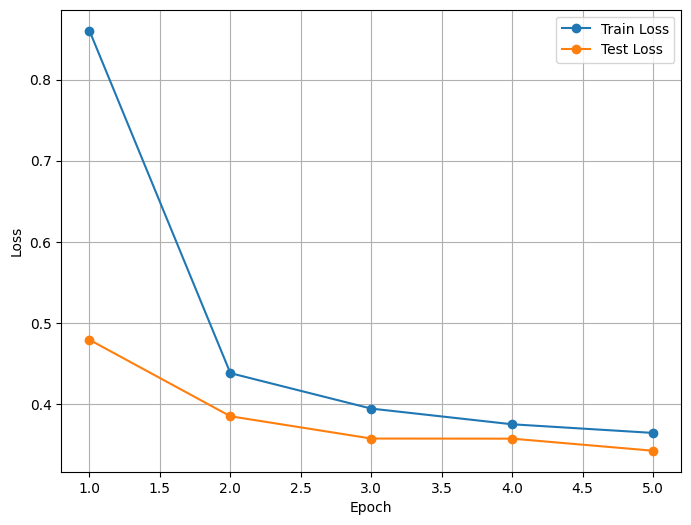

In [6]:
model.changeFlagLoader('mnist')
model.freezeParams()
model.myTrain('mnist')
model.plotGraphics()

In [7]:
model.unfreezeParams()
model.myTrain('mnist')
model.plotGraphics()

Epoch 1/5:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 5.7162, Test Loss: 0.3999


Epoch 2 - Train Loss: 0.3676, Test Loss: 0.3427


KeyboardInterrupt: 

In [ ]:
model.loadParams('firstHead.pth')
model.changeFlagLoader('mnist')
model.unfreezeParams()
model.myTrain('mnist')
model.plotGraphics()

Epoch 1/5:   2%|▏         | 10/600 [00:03<03:54,  2.52it/s, loss=3.4524]

bestProb : 0.1555


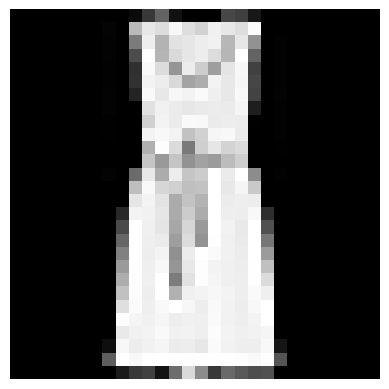

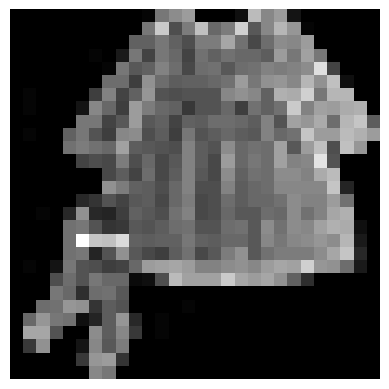

In [ ]:
model.changeFlagLoader('fashion')
firstLabel, secondLabel = 3, 9
bestImg, bestProb = model.findMostSimiliar(firstLabel, secondLabel)
anyImg = model.findRandomImage(firstLabel)
 
print(f'bestProb : {bestProb:.4f}')
model.plotImage(anyImg)
model.plotImage(bestImg)

In [ ]:
model.changeFlagLoader('mix')
model.myTrain('mix')
model.plotGraphics()

Epoch 1/5:  42%|████▏     | 166/400 [04:33<08:25,  2.16s/it, loss=2.6026]

: 

In [ ]:
model.changeFlagLoader('mix')
firstLabel, secondLabel = 3, 9
bestImg, bestProb = model.findMostSimiliar(firstLabel, secondLabel)
anyImg = model.findRandomImage(firstLabel)
 
print(f'bestProb : {bestProb:.4f}')
model.plotImage(anyImg)
model.plotImage(bestImg)

In [ ]:
model.changeFlagLoader('mix')
firstLabel, secondLabel = 11, 15
bestImg, bestProb = model.findMostSimiliar(firstLabel, secondLabel)
anyImg = model.findRandomImage(firstLabel)
 
print(f'bestProb : {bestProb:.4f}')
model.plotImage(anyImg)
model.plotImage(bestImg)